Data loaded. Shape: (5110, 12)

Categorical mappings applied successfully.

Final feature list: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'glucose_bmi_ratio', 'age_hypertension_interaction', 'risk_index']

Target distribution:
 stroke
0    4861
1     249
Name: count, dtype: int64

Train size: (4088, 13) Test size: (1022, 13)
After SMOTE (train): (7778, 13) {0: 3889, 1: 3889}

Training hybrid model (VotingClassifier)...
✅ Model training completed.

--- MODEL PERFORMANCE ---
Accuracy : 0.8718
Precision: 0.1478
Recall   : 0.34
F1 Score : 0.2061
ROC-AUC  : 0.7865

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.15      0.34      0.21        50

    accuracy                           0.87      1022
   macro avg       0.56      0.62      0.57      1022
weighted avg       0.92      0.87  

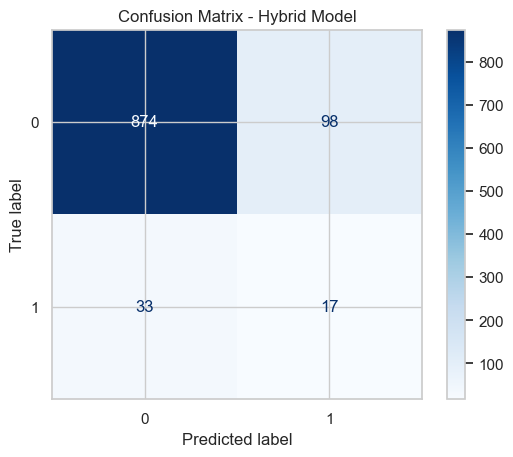


Preparing SHAP feature importance...
✅ Generating SHAP plots...


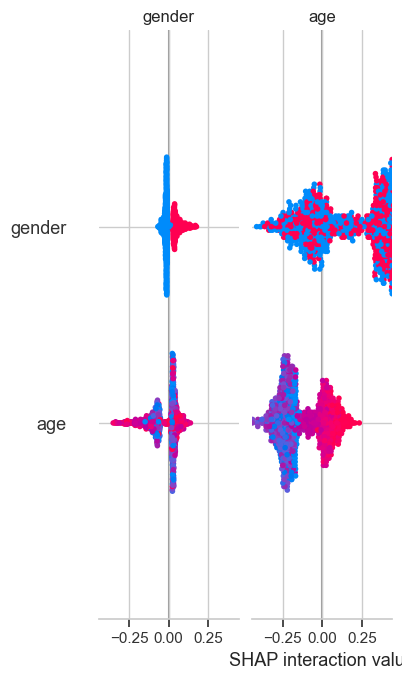

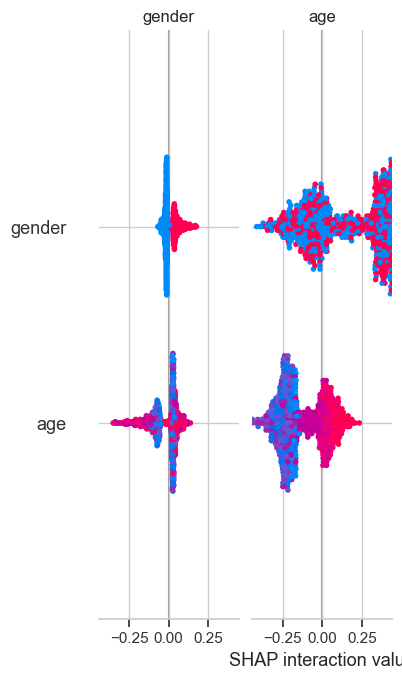

In [14]:
# ============================================================
# 🧠 EXPLAINABLE HYBRID MACHINE LEARNING SYSTEM FOR
# EARLY BRAIN STROKE RISK DETECTION
# ============================================================

# ---- STEP 1: Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# ---- STEP 2: Load Data ----
df = pd.read_csv("Stroke.csv")  # make sure this file path is correct
print(f"Data loaded. Shape: {df.shape}\n")

# ---- STEP 3: Data Cleaning ----
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Encode categorical columns
le = LabelEncoder()
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("Categorical mappings applied successfully.\n")

# ---- STEP 4: Feature Engineering ----
df['glucose_bmi_ratio'] = df['avg_glucose_level'] / (df['bmi'] + 1)
df['age_hypertension_interaction'] = df['age'] * df['hypertension']
df['risk_index'] = (0.4 * df['age']) + (0.3 * df['avg_glucose_level']) + (0.3 * df['bmi'])

feature_cols = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'glucose_bmi_ratio', 'age_hypertension_interaction', 'risk_index'
]

X = df[feature_cols]
y = df['stroke']

print("Final feature list:", list(X.columns))
print("\nTarget distribution:\n", y.value_counts())

# ---- STEP 5: Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape} Test size: {X_test.shape}")

# ---- STEP 6: Handle Class Imbalance ----
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f"After SMOTE (train): {X_train.shape} {{0: {sum(y_train==0)}, 1: {sum(y_train==1)}}}")

# ---- STEP 7: Feature Scaling ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- STEP 8: Hybrid Model ----
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hybrid_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)

print("\nTraining hybrid model (VotingClassifier)...")
hybrid_model.fit(X_train_scaled, y_train)
print("✅ Model training completed.\n")

# ---- STEP 9: Evaluation ----
y_pred = hybrid_model.predict(X_test_scaled)
y_prob = hybrid_model.predict_proba(X_test_scaled)[:, 1]

print("--- MODEL PERFORMANCE ---")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob), 4))

print("\nClassification report:\n", classification_report(y_test, y_pred))

# ---- STEP 10: Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

# ---- STEP 11: SHAP Explainability (Universal Safe Version) ----
print("\nPreparing SHAP feature importance...")

# Train a RandomForest solely for SHAP explanations
rf_shap = RandomForestClassifier(n_estimators=200, random_state=42)
rf_shap.fit(X_train_scaled, y_train)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_shap)
shap_values_raw = explainer.shap_values(X_test_scaled)

# Convert scaled data into DataFrame for plotting
X_test_shap = pd.DataFrame(X_test_scaled, columns=X.columns)

# --- Handle all SHAP output formats safely ---
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1] if len(shap_values_raw) > 1 else shap_values_raw[0]
else:
    shap_values = shap_values_raw

# Trim if SHAP added an extra bias column
if shap_values.shape[1] > X_test_shap.shape[1]:
    print(f"⚠️ Trimming SHAP output from {shap_values.shape[1]} → {X_test_shap.shape[1]} columns.")
    shap_values = shap_values[:, :X_test_shap.shape[1]]

# --- Generate plots ---
print("✅ Generating SHAP plots...")

shap.summary_plot(shap_values, X_test_shap, feature_names=X.columns, show=True)
shap.summary_plot(shap_values, X_test_shap, feature_names=X.columns, plot_type="bar", show=True)



In [12]:
# ----------------------------------------------------
# 🧠 Stroke Risk Detection - Interactive Version (Auto Model Detect)
# ----------------------------------------------------
import numpy as np
import pandas as pd

print("\n--- 🧠 Stroke Risk Detection System ---")

# ✅ Try to detect your model variable automatically
try:
    model = voting_clf
except NameError:
    try:
        model = hybrid_model
    except NameError:
        try:
            model = model
        except NameError:
            raise ValueError("❌ No trained model found. Please train your model first!")

# ✅ Detect your scaler variable
try:
    scaler = scaler
except NameError:
    raise ValueError("❌ No scaler found. Please define your StandardScaler used in training!")

# ----------------------------------------------------
# 🔍 Function to predict stroke risk
# ----------------------------------------------------
def predict_stroke_risk(model, scaler, patient_data):
    patient_df = pd.DataFrame([patient_data], columns=X.columns)
    patient_scaled = scaler.transform(patient_df)
    prob = model.predict_proba(patient_scaled)[0][1]
    pred = model.predict(patient_scaled)[0]
    return pred, prob

# ----------------------------------------------------
# 🧍‍♂️ Collect user input
# ----------------------------------------------------
def get_user_input():
    print("\nPlease enter the following patient details:\n")
    
    gender = int(input("Gender (0=Female, 1=Male): "))
    age = float(input("Age (in years): "))
    hypertension = int(input("Hypertension (0=No, 1=Yes): "))
    heart_disease = int(input("Heart Disease (0=No, 1=Yes): "))
    ever_married = int(input("Ever Married (0=No, 1=Yes): "))
    work_type = int(input("Work Type (0=children, 1=Govt_job, 2=Never_worked, 3=Private, 4=Self-employed): "))
    Residence_type = int(input("Residence Type (0=Rural, 1=Urban): "))
    avg_glucose_level = float(input("Average Glucose Level: "))
    bmi = float(input("BMI: "))
    smoking_status = int(input("Smoking Status (0=formerly smoked, 1=never smoked, 2=smokes): "))

    # Derived features (same as model training)
    glucose_bmi_ratio = avg_glucose_level / bmi if bmi != 0 else 0
    age_hypertension_interaction = age * hypertension
    risk_index = (avg_glucose_level * 0.3) + (bmi * 0.2) + (age * 0.5)
    
    patient_data = {
        "gender": gender,
        "age": age,
        "hypertension": hypertension,
        "heart_disease": heart_disease,
        "ever_married": ever_married,
        "work_type": work_type,
        "Residence_type": Residence_type,
        "avg_glucose_level": avg_glucose_level,
        "bmi": bmi,
        "smoking_status": smoking_status,
        "glucose_bmi_ratio": glucose_bmi_ratio,
        "age_hypertension_interaction": age_hypertension_interaction,
        "risk_index": risk_index
    }
    
    return patient_data

# ----------------------------------------------------
# 🚀 Run prediction interactively
# ----------------------------------------------------
patient_data = get_user_input()
prediction, probability = predict_stroke_risk(model, scaler, patient_data)

print("\n--- 🩺 Stroke Prediction Result ---")
if prediction == 1:
    print(f"⚠️ The patient is at **HIGH RISK** of stroke.")
else:
    print(f"✅ The patient is at **LOW RISK** of stroke.")

print(f"Predicted Probability of Stroke: {probability * 100:.2f}%")
print("----------------------------------------")



--- 🧠 Stroke Risk Detection System ---

Please enter the following patient details:



Gender (0=Female, 1=Male):  0
Age (in years):  18
Hypertension (0=No, 1=Yes):  1
Heart Disease (0=No, 1=Yes):  0
Ever Married (0=No, 1=Yes):  0
Work Type (0=children, 1=Govt_job, 2=Never_worked, 3=Private, 4=Self-employed):  2
Residence Type (0=Rural, 1=Urban):  0
Average Glucose Level:  160
BMI:  30
Smoking Status (0=formerly smoked, 1=never smoked, 2=smokes):  1



--- 🩺 Stroke Prediction Result ---
✅ The patient is at **LOW RISK** of stroke.
Predicted Probability of Stroke: 3.95%
----------------------------------------


Data loaded. Shape: (5110, 12)

Categorical mappings applied successfully.

Final feature list: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'glucose_bmi_ratio', 'age_hypertension_interaction', 'risk_index']

Target distribution:
 stroke
0    4861
1     249
Name: count, dtype: int64

Train size: (4088, 13) Test size: (1022, 13)
After SMOTE (train): (7778, 13) {0: 3889, 1: 3889}

Training hybrid model (VotingClassifier)...
✅ Model training completed.

--- MODEL PERFORMANCE ---
Accuracy : 0.8718
Precision: 0.1478
Recall   : 0.34
F1 Score : 0.2061
ROC-AUC  : 0.7865

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.15      0.34      0.21        50

    accuracy                           0.87      1022
   macro avg       0.56      0.62      0.57      1022
weighted avg       0.92      0.87  

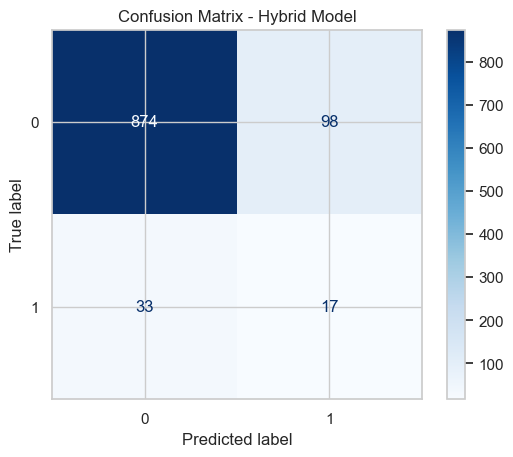


Preparing SHAP feature importance...
✅ Generating SHAP plots...


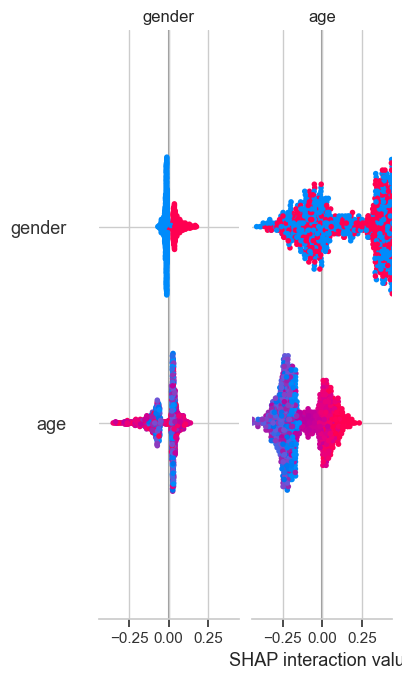

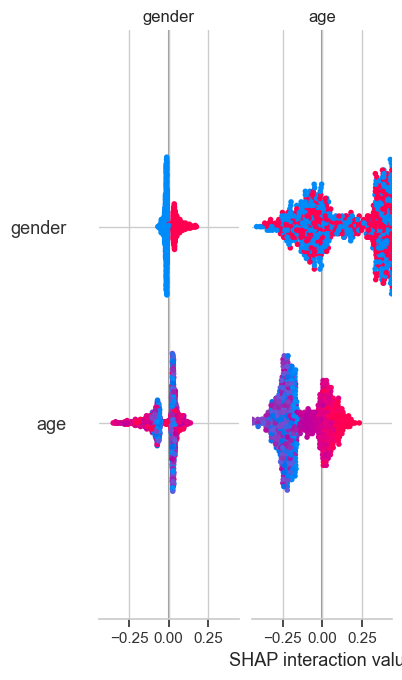


--- Stroke Risk Prediction System ---

--- 🧠 Stroke Risk Detection System ---

Please enter the following patient details:



Gender (0=Female, 1=Male):  0
Age (in years):  45
Hypertension (0=No, 1=Yes):  1
Heart Disease (0=No, 1=Yes):  0
Ever Married (0=No, 1=Yes):  1
Work Type (0=children, 1=Govt_job, 2=Never_worked, 3=Private, 4=Self-employed):  4
Residence Type (0=Rural, 1=Urban):  1
Average Glucose Level:  160
BMI:  20.7
Smoking Status (0=formerly smoked, 1=never smoked, 2=smokes):  1



--- 🩺 Stroke Prediction Result ---
✅ The patient is at **LOW RISK** of stroke.
Predicted Probability of Stroke: 6.64%
----------------------------------------


In [13]:
# ============================================================
# 🧠 EXPLAINABLE HYBRID MACHINE LEARNING SYSTEM FOR
# EARLY BRAIN STROKE RISK DETECTION
# ============================================================

# ---- STEP 1: Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# ---- STEP 2: Load Data ----
df = pd.read_csv("Stroke.csv")  # make sure this file path is correct
print(f"Data loaded. Shape: {df.shape}\n")

# ---- STEP 3: Data Cleaning ----
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Encode categorical columns
le = LabelEncoder()
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("Categorical mappings applied successfully.\n")

# ---- STEP 4: Feature Engineering ----
df['glucose_bmi_ratio'] = df['avg_glucose_level'] / (df['bmi'] + 1)
df['age_hypertension_interaction'] = df['age'] * df['hypertension']
df['risk_index'] = (0.4 * df['age']) + (0.3 * df['avg_glucose_level']) + (0.3 * df['bmi'])

feature_cols = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'glucose_bmi_ratio', 'age_hypertension_interaction', 'risk_index'
]

X = df[feature_cols]
y = df['stroke']

print("Final feature list:", list(X.columns))
print("\nTarget distribution:\n", y.value_counts())

# ---- STEP 5: Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain size: {X_train.shape} Test size: {X_test.shape}")

# ---- STEP 6: Handle Class Imbalance ----
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f"After SMOTE (train): {X_train.shape} {{0: {sum(y_train==0)}, 1: {sum(y_train==1)}}}")

# ---- STEP 7: Feature Scaling ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- STEP 8: Hybrid Model ----
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hybrid_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)

print("\nTraining hybrid model (VotingClassifier)...")
hybrid_model.fit(X_train_scaled, y_train)
print("✅ Model training completed.\n")

# ---- STEP 9: Evaluation ----
y_pred = hybrid_model.predict(X_test_scaled)
y_prob = hybrid_model.predict_proba(X_test_scaled)[:, 1]

print("--- MODEL PERFORMANCE ---")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob), 4))

print("\nClassification report:\n", classification_report(y_test, y_pred))

# ---- STEP 10: Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

# ---- STEP 11: SHAP Explainability (Universal Safe Version) ----
print("\nPreparing SHAP feature importance...")

# Train a RandomForest solely for SHAP explanations
rf_shap = RandomForestClassifier(n_estimators=200, random_state=42)
rf_shap.fit(X_train_scaled, y_train)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_shap)
shap_values_raw = explainer.shap_values(X_test_scaled)

# Convert scaled data into DataFrame for plotting
X_test_shap = pd.DataFrame(X_test_scaled, columns=X.columns)

# --- Handle all SHAP output formats safely ---
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1] if len(shap_values_raw) > 1 else shap_values_raw[0]
else:
    shap_values = shap_values_raw

# Trim if SHAP added an extra bias column
if shap_values.shape[1] > X_test_shap.shape[1]:
    print(f"⚠️ Trimming SHAP output from {shap_values.shape[1]} → {X_test_shap.shape[1]} columns.")
    shap_values = shap_values[:, :X_test_shap.shape[1]]

# --- Generate plots ---
print("✅ Generating SHAP plots...")

shap.summary_plot(shap_values, X_test_shap, feature_names=X.columns, show=True)
shap.summary_plot(shap_values, X_test_shap, feature_names=X.columns, plot_type="bar", show=True)


# ============================================================
# 🧍 USER INTERACTIVE STROKE RISK PREDICTION
# ============================================================

print("\n--- Stroke Risk Prediction System ---")

import numpy as np
import pandas as pd

print("\n--- 🧠 Stroke Risk Detection System ---")

# ✅ Try to detect your model variable automatically
try:
    model = voting_clf
except NameError:
    try:
        model = hybrid_model
    except NameError:
        try:
            model = model
        except NameError:
            raise ValueError("❌ No trained model found. Please train your model first!")

# ✅ Detect your scaler variable
try:
    scaler = scaler
except NameError:
    raise ValueError("❌ No scaler found. Please define your StandardScaler used in training!")

# ----------------------------------------------------
# 🔍 Function to predict stroke risk
# ----------------------------------------------------
def predict_stroke_risk(model, scaler, patient_data):
    patient_df = pd.DataFrame([patient_data], columns=X.columns)
    patient_scaled = scaler.transform(patient_df)
    prob = model.predict_proba(patient_scaled)[0][1]
    pred = model.predict(patient_scaled)[0]
    return pred, prob

# ----------------------------------------------------
# 🧍‍♂️ Collect user input
# ----------------------------------------------------
def get_user_input():
    print("\nPlease enter the following patient details:\n")
    
    gender = int(input("Gender (0=Female, 1=Male): "))
    age = float(input("Age (in years): "))
    hypertension = int(input("Hypertension (0=No, 1=Yes): "))
    heart_disease = int(input("Heart Disease (0=No, 1=Yes): "))
    ever_married = int(input("Ever Married (0=No, 1=Yes): "))
    work_type = int(input("Work Type (0=children, 1=Govt_job, 2=Never_worked, 3=Private, 4=Self-employed): "))
    Residence_type = int(input("Residence Type (0=Rural, 1=Urban): "))
    avg_glucose_level = float(input("Average Glucose Level: "))
    bmi = float(input("BMI: "))
    smoking_status = int(input("Smoking Status (0=formerly smoked, 1=never smoked, 2=smokes): "))

    # Derived features (same as model training)
    glucose_bmi_ratio = avg_glucose_level / bmi if bmi != 0 else 0
    age_hypertension_interaction = age * hypertension
    risk_index = (avg_glucose_level * 0.3) + (bmi * 0.2) + (age * 0.5)
    
    patient_data = {
        "gender": gender,
        "age": age,
        "hypertension": hypertension,
        "heart_disease": heart_disease,
        "ever_married": ever_married,
        "work_type": work_type,
        "Residence_type": Residence_type,
        "avg_glucose_level": avg_glucose_level,
        "bmi": bmi,
        "smoking_status": smoking_status,
        "glucose_bmi_ratio": glucose_bmi_ratio,
        "age_hypertension_interaction": age_hypertension_interaction,
        "risk_index": risk_index
    }
    
    return patient_data

# ----------------------------------------------------
# 🚀 Run prediction interactively
# ----------------------------------------------------
patient_data = get_user_input()
prediction, probability = predict_stroke_risk(model, scaler, patient_data)

print("\n--- 🩺 Stroke Prediction Result ---")
if prediction == 1:
    print(f"⚠️ The patient is at **HIGH RISK** of stroke.")
else:
    print(f"✅ The patient is at **LOW RISK** of stroke.")

print(f"Predicted Probability of Stroke: {probability * 100:.2f}%")
print("----------------------------------------")


In [ ]:
# ---- STEP 1: Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# ---- STEP 2: Load Data ----
df = pd.read_csv("Stroke.csv")
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# ---- STEP 3: Feature Engineering ----
df['glucose_bmi_ratio'] = df['avg_glucose_level'] / (df['bmi'] + 1)
df['age_hypertension_interaction'] = df['age'] * df['hypertension']
df['risk_index'] = (0.4 * df['age']) + (0.3 * df['avg_glucose_level']) + (0.3 * df['bmi'])

feature_cols = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'glucose_bmi_ratio', 'age_hypertension_interaction', 'risk_index'
]

X = df[feature_cols]
y = df['stroke']

# ---- STEP 4: Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- STEP 5: SMOTE ----
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# ---- STEP 6: Scaling ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# ---- STEP 7: Hybrid Model ----
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

hybrid_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb)],
    voting='soft'
)

print("\nTraining Hybrid Model...")
hybrid_model.fit(X_train_scaled, y_train_bal)
print("Model training completed.\n")

# ---- STEP 8: Evaluation ----
y_pred = hybrid_model.predict(X_test_scaled)
y_prob = hybrid_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- MODEL PERFORMANCE ---")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# ======================================================
#        🚀 CORRECTED SHAP IMPLEMENTATION
# ======================================================

print("\nPreparing SHAP explainability...")

# SHAP must use unscaled data for tree models
rf_shap = RandomForestClassifier(n_estimators=200, random_state=42)
rf_shap.fit(X_train_bal, y_train_bal)

explainer = shap.TreeExplainer(rf_shap)
shap_values_raw = explainer.shap_values(X_test)

# If SHAP output is list → choose class 1
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]
else:
    shap_values = shap_values_raw

X_test_shap = X_test.copy()

print("Generating SHAP Beeswarm and Bar Plots...")

# Beeswarm
shap.summary_plot(
    shap_values,
    X_test_shap,
    plot_type="dot",
    feature_names=X.columns,
    show=True
)

# Bar Plot
shap.summary_plot(
    shap_values,
    X_test_shap,
    plot_type="bar",
    feature_names=X.columns,
    show=True
)


# ======================================================
#     🧠 USER INTERACTIVE PREDICTION (ORIGINAL VERSION)
# ======================================================

print("\n--- Stroke Risk Prediction System ---")
print("\n--- Stroke Risk Detection System ---")

# Auto-detect model
try:
    model = voting_clf
except:
    model = hybrid_model

def predict_stroke_risk(model, scaler, patient_data):
    patient_df = pd.DataFrame([patient_data], columns=X.columns)
    patient_scaled = scaler.transform(patient_df)
    prob = model.predict_proba(patient_scaled)[0][1]
    pred = model.predict(patient_scaled)[0]
    return pred, prob

def get_user_input():
    print("\nPlease enter the following patient details:\n")

    gender = int(input("Gender (0=Female, 1=Male): "))
    age = float(input("Age (in years): "))
    hypertension = int(input("Hypertension (0=No, 1=Yes): "))
    heart_disease = int(input("Heart Disease (0=No, 1=Yes): "))
    ever_married = int(input("Ever Married (0=No, 1=Yes): "))
    work_type = int(input("Work Type (0=children, 1=Govt_job, 2=Never_worked, 3=Private, 4=Self-employed): "))
    Residence_type = int(input("Residence Type (0=Rural, 1=Urban): "))
    avg_glucose_level = float(input("Average Glucose Level: "))
    bmi = float(input("BMI: "))
    smoking_status = int(input("Smoking Status (0=formerly smoked, 1=never smoked, 2=smokes): "))

    glucose_bmi_ratio = avg_glucose_level / bmi if bmi != 0 else 0
    age_hypertension_interaction = age * hypertension
    risk_index = (avg_glucose_level * 0.3) + (bmi * 0.2) + (age * 0.5)

    patient_data = {
        "gender": gender,
        "age": age,
        "hypertension": hypertension,
        "heart_disease": heart_disease,
        "ever_married": ever_married,
        "work_type": work_type,
        "Residence_type": Residence_type,
        "avg_glucose_level": avg_glucose_level,
        "bmi": bmi,
        "smoking_status": smoking_status,
        "glucose_bmi_ratio": glucose_bmi_ratio,
        "age_hypertension_interaction": age_hypertension_interaction,
        "risk_index": risk_index
    }
    return patient_data

patient_data = get_user_input()
prediction, probability = predict_stroke_risk(model, scaler, patient_data)

print("\n--- 🩺 Stroke Prediction Result ---")
if prediction == 1:
    print("The patient is at **HIGH RISK** of stroke.")
else:
    print("The patient is at **LOW RISK** of stroke.")

print(f"Predicted Probability of Stroke: {probability * 100:.2f}%")
print("----------------------------------------")
